# Advanced Usage Example

In this example we cover advanced usage of `BoolXAI.RuleClassifier`. 

## Input data

We'll start with the same binarized data we used in the Basic Usage Example. In order to speed up the execution, we'll only use a subset of the data:

In [1]:
from sklearn import set_config

set_config(transform_output="pandas")

from sklearn import datasets

X, y = datasets.load_breast_cancer(return_X_y=True, as_frame=True)

# Use a subset of the data to speed up execution.
# For higher quality results, comment these lines out.
X = X.iloc[:100, :100]
y = y.iloc[:100]

# Binarize the data
from util import BoolXAIKBinsDiscretizer

binarizer = BoolXAIKBinsDiscretizer(
    n_bins=10, strategy="quantile", encode="onehot-dense"
)
X_binarized = binarizer.fit_transform(X)

X_binarized.head();

## Number of starts

Each training run consists of `num_starts` starts. The best rule and score for each start can be accessed in the `rules_` and `scores_` attributes (respectively). Next we'll train a classifier and inspect these attributes. 

In [2]:
from boolxai import BoolXAI

rule_classifier = BoolXAI.RuleClassifier(random_state=43)
rule_classifier.fit(X_binarized, y)

print("Best score and rule:")
print(f"  score={rule_classifier.best_score_:.2f} rule={rule_classifier.best_rule_}\n")

print("Best score and rule for each start:")
for score, rule in zip(rule_classifier.scores_, rule_classifier.rules_):
    print(f"  {score=:.2f} {rule=}")

Best score and rule:
  score=0.91 rule=Or(230, 50, 271, 222)

Best score and rule for each start:
  score=0.81 rule=Or(251, 120, 261, 160)
  score=0.73 rule=AtMost1(~171, And(257, ~246), ~130)
  score=0.74 rule=AtMost1(~50, ~30, 109)
  score=0.86 rule=Or(20, 92, 72, 71, 231)
  score=0.71 rule=Choose1(~225, And(9, ~37), 195)
  score=0.78 rule=Choose1(~205, 28, 206, 256, 64)
  score=0.76 rule=AtMost1(~261, ~202, 126)
  score=0.71 rule=AtMost1(~101, ~270, 296)
  score=0.74 rule=AtLeast2(220, 72, Choose1(138, ~129))
  score=0.91 rule=Or(230, 50, 271, 222)


## Bagging

Bagging or "boostrap aggregation" is commonly used to select only a partial sample of the dataset to avoid overfitting. It is often applied to single estimators that are then combined to form an ensemble estimator. In our case, our model is already highly regularized, so it's unlikely to overfit the data (unless it's very small/simple). For this reason, combined with the binary inputs, it's unnecessary to feed it huge amounts of data. So, in this case we use bagging not to mitigate overfitting, but rather to boost performance, since evaluation of rules scales linearly with the number of samples.

In the rule classifier, one can control the level of bagging using the parameter `max_samples`. It controls the maximum number of samples that will be used in each start, with a default of 2,000. For large datasets, this can make a big difference. Note that the `best_rule_` attribute is populated with the best rule as evaluated over the whole (train) dataset, not only `max_samples`.

Let's look at an example: 

In [3]:
%%time

rule_classifier = BoolXAI.RuleClassifier(random_state=43)
rule_classifier.fit(X_binarized, y)
print("Without bagging:")
print(f"score={rule_classifier.best_score_:.2f} rule={rule_classifier.best_rule_}\n")

Without bagging:
score=0.91 rule=Or(230, 50, 271, 222)

CPU times: user 21.3 ms, sys: 5.04 ms, total: 26.3 ms
Wall time: 5.84 s


In [4]:
%%time

rule_classifier = BoolXAI.RuleClassifier(
    random_state=43, max_samples=len(X_binarized) // 5
)
rule_classifier.fit(X_binarized, y)
print("With bagging:")
print(f"score={rule_classifier.best_score_:.2f} rule={rule_classifier.best_rule_}\n")

With bagging:
score=0.76 rule=Choose1(244, 226, ~168, 217, 219)

CPU times: user 61 ms, sys: 6.37 ms, total: 67.4 ms
Wall time: 2.7 s


The wall clock time was much shorter, but the result was worse. That's expected for such a small dataset - using 20 samples for each start is not representative. However, for larger datasets we have observed that one can get a significant reduction in run time without a significant change in score. 

## Parallelization

Since the runtime for training the classifier can be significant, it's useful to parallelize the computation. The number of parallel jobs (starts, in this case) is controlled by the argument `num_jobs`. We can probe the dependence of the runtime on `num_jobs` with a small experiment (results are dependent on the machine you are using):

In [5]:
import time
import matplotlib.pyplot as plt

seed = 42
rule_classifier = BoolXAI.RuleClassifier(
    num_starts=24, num_iterations=100, random_state=seed
)

all_num_jobs = [24, 12, 8, 4, 2, 1]
times = []
for num_jobs in all_num_jobs:
    rule_classifier.num_jobs = num_jobs
    start_time = time.time()
    rule_classifier.fit(X_binarized, y)
    elapsed_time = time.time() - start_time
    times.append(elapsed_time)

    print(
        f"{num_jobs=}, {elapsed_time=:.2f} sec, {rule_classifier.best_score_:.3}, {rule_classifier.best_rule_}"
    )

num_jobs=24, elapsed_time=7.77 sec, 0.834, AtLeast1(160, 21, 30, 261)
num_jobs=12, elapsed_time=6.02 sec, 0.834, AtLeast1(160, 21, 30, 261)
num_jobs=8, elapsed_time=4.22 sec, 0.834, AtLeast1(160, 21, 30, 261)
num_jobs=4, elapsed_time=6.91 sec, 0.834, AtLeast1(160, 21, 30, 261)
num_jobs=2, elapsed_time=11.32 sec, 0.834, AtLeast1(160, 21, 30, 261)
num_jobs=1, elapsed_time=18.35 sec, 0.834, AtLeast1(160, 21, 30, 261)


It is clear that we can get a large speedup by using multiple cores. Note that the rule and score are the same, as expected, since we used the same seed. We see that there is a sweet spot located at the number of cores of the machine we are using (note: using the full data is advisable to get more representative results):

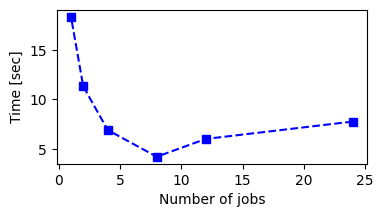

In [6]:
plt.figure(figsize=(4, 2))
plt.plot(all_num_jobs, times, "s--b")
plt.xlabel("Number of jobs")
plt.ylabel("Time [sec]")
plt.show()

## Cross validation

Cross-validation is often used in order to quantify a model's generalization ability, as well as for hyperparameter optimization. Below we provide an example of running cross-validation for a rule classifier. Here we switch off the internal parallelization over starts, instead parallelizing over the cross-validation splits. Note that the binarization is data-dependent, so we make sure to run it separately on each split. This is done by instantiating an `sklearn`  `Pipeline` consisting of a binarizer and a rule classifier:

In [7]:
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline, make_pipeline
import numpy as np

# Define the pipeline
rule_classifier = BoolXAI.RuleClassifier(num_jobs=1, random_state=seed)
binarizer = BoolXAIKBinsDiscretizer(
    n_bins=10, strategy="quantile", encode="onehot-dense"
)
pipeline = make_pipeline(binarizer, rule_classifier)

# Run cross-validation
cv = StratifiedShuffleSplit(n_splits=8, train_size=0.7, random_state=seed)
result = cross_validate(
    pipeline,
    X,
    y,
    cv=cv,
    n_jobs=-1,  # Parallelization here, instead of inside classifier
    return_train_score=True,
    return_estimator=True,
    error_score="raise",
)

print(
    f"""Train={np.mean(result["train_score"]):.2f}+-{np.std(result["train_score"]):.2f}, Time={np.mean(result["fit_time"]):.2f}+-{np.std(result["fit_time"]):.2f}sec"""
)
print(
    f"""Test={np.mean(result["test_score"]):.2f}+-{np.std(result["test_score"]):.2f}"""
)

Train=0.92+-0.03, Time=36.68+-0.68sec
Test=0.80+-0.08


## Pareto frontier

In most cases there isn't a clear reason to choose a specific `max_complexity` value. In general, we might expect that higher values will provide more expressivity and therefore higher metric scores, but this is not guaranteed. For these reasons, it's often a good idea to find the best rule for multiple `max_complexity` values. Viewing the resulting curve (the Pareto frontier) in the metric-complexity 2D space is instructive. We show an example of how to do this using cross-validation. Warning, this cell might take a few minutes to run!

In [8]:
# Run cross-validation
train_scores = []
test_scores = []
fit_times = []
complexities = []

for max_complexity in [3, 6, 10, 15]:
    # Use the pipeline we instantiated earlier, adjusting max_complexity
    pipeline.set_params(ruleclassifier__max_complexity=max_complexity)

    result = cross_validate(
        pipeline,
        X,
        y,
        cv=cv,
        n_jobs=-1,  # Parallelization here, instead of inside classifier
        return_train_score=True,
        return_estimator=True,
        error_score="raise",
    )

    train_score = np.mean(result["train_score"])
    train_scores.append(train_score)

    test_score = np.mean(result["test_score"])
    test_scores.append(test_score)

    fit_time = np.mean(result["fit_time"])
    fit_times.append(fit_time)

    pipelines = result["estimator"]
    mean_complexity = np.mean(
        [pipeline[-1].best_rule_.complexity() for pipeline in pipelines]
    )
    complexities.append(mean_complexity)

    print(
        f"{max_complexity=}, {mean_complexity=}, {train_score=:.2f}, {test_score=:.2f}, {fit_time=:.2f}sec"
    )

max_complexity=3, mean_complexity=3.0, train_score=0.78, test_score=0.71, fit_time=22.41sec
max_complexity=6, mean_complexity=5.75, train_score=0.92, test_score=0.80, fit_time=30.02sec
max_complexity=10, mean_complexity=8.125, train_score=0.91, test_score=0.80, fit_time=41.83sec
max_complexity=15, mean_complexity=9.75, train_score=0.94, test_score=0.79, fit_time=60.93sec


We can plot the results for easier comparison. Note that we make sure to use the mean of the complexities of the resulting rules on the x axis, and not the respective `max_complexity` (which is an upper bound on the former):

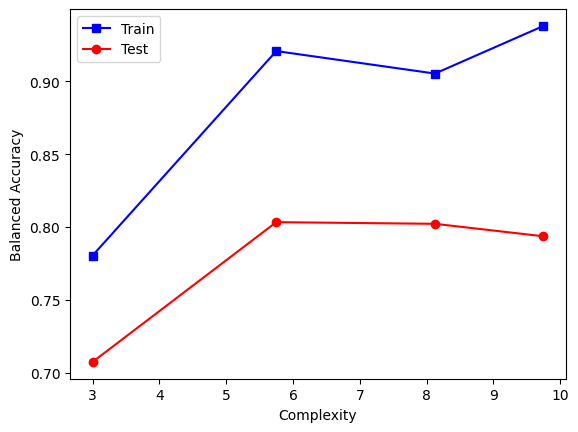

In [9]:
plt.figure()
plt.plot(complexities, train_scores, "s-b", label="Train")
plt.plot(complexities, test_scores, "o-r", label="Test")
plt.legend()
plt.xlabel("Complexity")
plt.ylabel("Balanced Accuracy")
plt.show()

## Rule class diagram

For the next two sections, it will be useful to refer to the rule class diagram:

![title](rule_class_diagram.png)

Note that only the leaves are concrete classes - specific operators, literals, or trivial rules. The rest of the classes are abstract classes. The `Operator` class is not actually implemented, it is only pictured for clearer presentation. 

## Changing the allowed operators

The rule classifier has an argument `operators` which by default includes all the operators provided in `boolxai`. But what if we want to allow only some of the operators? As an example, we might want to only include the unparameterized operators `And` and `Or`. We can do that like so:

In [10]:
from boolxai import Operator

rule_classifier = BoolXAI.RuleClassifier(
    random_state=43, operators=[Operator.And, Operator.Or]
)
rule_classifier.fit(X_binarized, y);

We can inspect the best rule seen, as well as the best rule for each start, to make sure that they indeed include only those operators:

In [11]:
print("Best score and rule:")
print(f"  score={rule_classifier.best_score_:.2f} rule={rule_classifier.best_rule_}\n")

print("Best score and rule for each start:")
for score, rule in zip(rule_classifier.scores_, rule_classifier.rules_):
    print(f"  {score=:.2f} {rule=}")

Best score and rule:
  score=0.93 rule=Or(252, 222, 220, 201, 33)

Best score and rule for each start:
  score=0.71 rule=And(Or(~205, 42), ~109, ~267)
  score=0.87 rule=Or(71, 170, 250, 200, 62)
  score=0.93 rule=Or(252, 222, 220, 201, 33)
  score=0.80 rule=Or(232, 190, 0)
  score=0.76 rule=And(~38, Or(230, 23, 41))
  score=0.89 rule=Or(220, 222, 272, 221)
  score=0.80 rule=And(Or(192, 30, 272), ~9)
  score=0.81 rule=Or(251, 130, 260, 261)
  score=0.71 rule=Or(And(~126, 1, ~296), 270)
  score=0.92 rule=Or(230, 150, 232, 252, 202)


## Adding custom operators

We can even add custom operators. To do so, we follow the template of the included operators in `boolxai.rules.operators`. In particular, we must subclass `UnparametrizedOperator` or `ParametrizedOperator`, and implement the `_evaluate()` method. Let's add the `AllEqual()` operator, which returns `True` only if all included literals are true:

In [12]:
from typing import List, Optional, Union

from boolxai import Literal
from boolxai import UnparametrizedOperator


class AllEqual(UnparametrizedOperator):
    """Returns True if all subrules are equal."""

    def _evaluate(self, state):
        sum_subrules = np.sum(
            np.column_stack([subrule.evaluate(state) for subrule in self.subrules]),
            axis=1,
        )
        return np.logical_or(sum_subrules == 0, sum_subrules == len(self.subrules))

Let's try our new operator to see if it works as expected:

In [13]:
X = np.array([[0, 0, 1], [0, 0, 0], [0, 1, 1], [1, 1, 1], [1, 0, 0]])

rule = AllEqual([Literal(0, negated=True), Literal(1), Literal(2)])
rule.evaluate(X)

array([False, False,  True, False,  True])

Indeed, the result we were expecting! Now we can include this operator class in the training of the rule classifier:

In [14]:
rule_classifier = BoolXAI.RuleClassifier(
    random_state=43, operators=[Operator.And, AllEqual]
)
rule_classifier.fit(X_binarized, y);

Once again, we can inspect the rules:

In [15]:
print("Best score and rule:")
print(f"  score={rule_classifier.best_score_:.2f} rule={rule_classifier.best_rule_}\n")

print("Best score and rule for each start:")
for score, rule in zip(rule_classifier.scores_, rule_classifier.rules_):
    print(f"  {score=:.2f} {rule=}")

Best score and rule:
  score=0.85 rule=AllEqual(And(~230, ~21), 232)

Best score and rule for each start:
  score=0.82 rule=AllEqual(~28, ~205, ~265, ~249, ~206)
  score=0.74 rule=AllEqual(72, ~70)
  score=0.76 rule=AllEqual(~261, 260)
  score=0.85 rule=AllEqual(And(~230, ~21), 232)
  score=0.81 rule=AllEqual(~239, ~225, ~178, ~88, ~7)
  score=0.78 rule=AllEqual(~62, AllEqual(270, ~61))
  score=0.81 rule=AllEqual(And(~230, ~262, ~263), 212)
  score=0.83 rule=AllEqual(109, 66, 235, 78, 219)
  score=0.80 rule=AllEqual(~274, ~179, ~299, ~138, ~207)
  score=0.76 rule=AllEqual(AllEqual(79, ~136), 76, 108)


We see that the only operators appearing in these rules are `And` and our new operator `AllEqual`, as expected. In this example we added an unparameterized operator. Adding parameterized operators follows the same pattern, provided that the operators have one integer parameter $k$ for which $1 \leq k \leq \tilde{m}$ where $\tilde{m}$ is the number of subrules of the operator. The value of $k$ is set on the fly by the rule classifier so that it is always in that range. 

## Optimizing part of a rule

We can also find the best subrule, given a pre-determined base rule. For example, we might already know that two features `f1` and `f2` are well correlated with the target (labels), and we'd like them to definitely be included. Then, we can formulate the problem as optimizing over `Or(f1, f2, *)`, where `*` is the part to be optimized over, which we refer to as the "wildcard node". We'll show how to do this step by step below.

First, let us construct a rule containing two chosen features. We use two literals that appear in the best solution found at the top of this notebook:

In [16]:
from sklearn.metrics import balanced_accuracy_score

rule = Operator.Or([Literal(230), Literal(50)])
rule

Or(230, 50)

We can check the score that this rule obtains on the dataset directly by using the rule's `evaluate()` method, followed by an application of the metric (in this case balanced accuracy):

In [17]:
y_predict = rule.evaluate(X_binarized.values)
score = balanced_accuracy_score(y, y_predict)
print(f"{score=:.2f}")

score=0.74


Now we'd like to add the additional wildcard node to this rule and optimize over that part of the rule. This node will be replaced by the result of the optimization we will run:

In [18]:
from boolxai import Wildcard

base_rule = Operator.Or([Literal(230), Literal(50), Wildcard()])

print("Rule before", base_rule)

Rule before Or(230, 50, *)


We instantiate a new `RuleClassifier` as done previously, but this time we pass in the `base_rule` containing the wildcard node:

In [19]:
rule_classifier = BoolXAI.RuleClassifier(random_state=43, base_rule=base_rule)
rule_classifier.fit(X_binarized, y)
print("Rule after", rule_classifier.best_rule_)

Rule after Or(230, 50, 222, 291)


Now we can evaluate the new rule, with the optimized subtree:

In [20]:
y_predict = rule_classifier.best_rule_.evaluate(X_binarized.values)
score = balanced_accuracy_score(y, y_predict)
print(f"{score=:.2f}")

score=0.90


Or we can just obtain the score from the classifier, and of course they match:

In [21]:
print("Best score and rule:")
print(f"  score={rule_classifier.best_score_:.2f} rule={rule_classifier.best_rule_}")

Best score and rule:
  score=0.90 rule=Or(230, 50, 222, 291)


As before, we can also print the rule and score found in each start. In this case, we can verify that all the rules contain our base rule: 

In [22]:
print("Best score and rule for each start:")
for score, rule in zip(rule_classifier.scores_, rule_classifier.rules_):
    print(f"  {score=:.2f} {rule=}")

Best score and rule for each start:
  score=0.87 rule=Or(230, 50, 1, 232)
  score=0.83 rule=Or(230, 50, Choose1(197, 272))
  score=0.85 rule=Or(230, 50, 222)
  score=0.85 rule=Or(230, 50, 222)
  score=0.85 rule=Or(230, 50, 222)
  score=0.85 rule=Or(230, 50, 222)
  score=0.86 rule=Or(230, 50, AtMost1(~142, ~272))
  score=0.88 rule=Or(230, 50, 171, 62)
  score=0.85 rule=Or(230, 50, 222)
  score=0.90 rule=Or(230, 50, 222, 291)
